Muhammed Enes Ugras

Nurten Ciftcioglu

# Steam Game Price Prediction - Modeling & Evaluation

This notebook builds a complete preprocessing Pipeline from scratch and trains models to predict game prices. All preprocessing steps documented in Notebook 02 are implemented here as sklearn-compatible transformers.

In [ ]:
!pip install xgboost


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install lightgbm


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, HuberRegressor, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Local
# this csv created after 01_presplit_cleaning_eda.ipynb
#df = pd.read_csv('cleaned_presplit_games_data.csv', parse_dates=['Release date'])

# Colab + Drive, provide your path
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/ml/ml_project_dataset/cleaned_presplit_games_data.csv"

df = pd.read_csv(file_path, parse_dates=['Release date'])

df.shape

(81298, 17)

In [ ]:
# Finding cutoff date for 80/20 time-based split
df_sorted = df.sort_values('Release date')
cutoff_idx = int(len(df_sorted) * 0.80)
cutoff_date = df_sorted.iloc[cutoff_idx]['Release date']

pd.DataFrame({
    'Metric': ['Cutoff Date', 'Train (before)', 'Test (on/after)', 'Train %'],
    'Value': [
        str(cutoff_date.date()),
        (df['Release date'] < cutoff_date).sum(),
        (df['Release date'] >= cutoff_date).sum(),
        f"{(df['Release date'] < cutoff_date).sum() / len(df) * 100:.1f}%"
    ]
})

,Metric,Value
0,Cutoff Date,2023-12-12
1,Train (before),65016
2,Test (on/after),16282
3,Train %,80.0%


In [ ]:
train_df = df[df['Release date'] < cutoff_date].copy()
test_df = df[df['Release date'] >= cutoff_date].copy()

pd.DataFrame({
    'Set': ['Train', 'Test'],
    'Count': [len(train_df), len(test_df)]
})

,Set,Count
0,Train,65016
1,Test,16282


#### Build Preprocessing Pipeline

In [ ]:
# Outlier Capper
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, caps):
        self.caps = caps

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col, max_val in self.caps.items():
            if col in X.columns:
                X[col] = X[col].clip(upper=max_val)
        return X

In [ ]:
# Missing Value Handler (NO row dropping)
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['has_tags'] = X['Tags'].notna().astype(int)
        X['Tags'] = X['Tags'].fillna('')
        return X

In [ ]:
# Date Feature Extractor
class DateFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['release_year'] = X['Release date'].dt.year
        X['release_month'] = X['Release date'].dt.month
        X['release_day_of_week'] = X['Release date'].dt.dayofweek

        # Season
        def get_season(month):
            if month in [12, 1, 2]: return 'Winter'
            elif month in [3, 4, 5]: return 'Spring'
            elif month in [6, 7, 8]: return 'Summer'
            else: return 'Fall'

        X['release_season'] = X['release_month'].apply(get_season)
        X = X.drop(columns=['Release date'])
        return X

In [ ]:
# Log Transformer
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X[f'log_{col.lower()}'] = np.log1p(X[col])
        return X

In [ ]:
# Multi-Label Encoder
class MultiLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column, prefix, top_n=None, exclude=None):
        self.column = column
        self.prefix = prefix
        self.top_n = top_n
        self.exclude = exclude  # Don't modify! Keep as-is for sklearn clone

    def fit(self, X, y=None):
        # Handle exclude here instead of __init__
        exclude_list = self.exclude if self.exclude is not None else []

        # Parse all labels
        all_labels = []
        for val in X[self.column].dropna():
            labels = [l.strip() for l in str(val).split(',') if l.strip()]
            all_labels.extend(labels)

        # Count frequency
        from collections import Counter
        freq = Counter(all_labels)

        # Filter
        if self.top_n:
            self.classes_ = [l for l, _ in freq.most_common(self.top_n) if l not in exclude_list]
        else:
            self.classes_ = [l for l in freq.keys() if l not in exclude_list]

        return self

    def transform(self, X):
        X = X.copy()

        # Create binary columns
        for label in self.classes_:
            col_name = f"{self.prefix}_{label.replace(' ', '_').replace('-', '_')}"
            X[col_name] = X[self.column].apply(
                lambda x: 1 if pd.notna(x) and label in str(x) else 0
            )

        return X

In [ ]:
# Tag Count Creator
class TagCountCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['tag_count'] = X['Tags'].apply(
            lambda x: len([t for t in str(x).split(',') if t.strip()]) if pd.notna(x) and x != '' else 0
        )
        return X


In [ ]:
# Column Dropper & Season Encoder
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        cols_to_drop = [c for c in self.columns if c in X.columns]
        return X.drop(columns=cols_to_drop)

class SeasonEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for season in ['Winter', 'Spring', 'Summer', 'Fall']:
            X[f'season_{season}'] = (X['release_season'] == season).astype(int)
        X = X.drop(columns=['release_season'])
        return X

In [ ]:
# Numeric Scaler
class NumericScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler = None

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        cols_to_scale = [c for c in self.columns if c in X.columns]
        if cols_to_scale:
            self.scaler.fit(X[cols_to_scale])
        self.fitted_columns_ = cols_to_scale
        return self

    def transform(self, X):
        X = X.copy()
        if self.fitted_columns_:
            X[self.fitted_columns_] = self.scaler.transform(X[self.fitted_columns_])
        return X

In [ ]:
numeric_to_scale = [
    'log_description_length', 'log_supported_lang_count', 'log_audio_lang_count',
    'release_year', 'release_month', 'release_day_of_week', 'tag_count', 'Required age'
]

preprocessing_pipeline = Pipeline([
    ('outlier_cap', OutlierCapper({'supported_lang_count': 29, 'audio_lang_count': 13})),
    ('missing_handler', MissingValueHandler()),
    ('date_extractor', DateFeatureExtractor()),
    ('log_transform', LogTransformer(['description_length', 'supported_lang_count', 'audio_lang_count'])),
    ('genre_encoder', MultiLabelEncoder('Genres', 'genre', exclude=['Early Access'])),
    ('category_encoder', MultiLabelEncoder('Categories', 'cat')),
    ('tag_encoder', MultiLabelEncoder('Tags', 'tag', top_n=100)),
    ('tag_count', TagCountCreator()),
    ('season_encoder', SeasonEncoder()),
    ('drop_cols', ColumnDropper(['Genres', 'Categories', 'Tags', 'Windows',
                                  'has_english_lang_support', 'description_length',
                                  'supported_lang_count', 'audio_lang_count', 'AppID', 'Name'])),
    ('scaler', NumericScaler(numeric_to_scale))
])

#### Prepare Raw features and target for Cross-Validation



In [ ]:
# Drop rows with missing Genres or Categories BEFORE splitting X and y
mask_train = train_df['Genres'].notna() & train_df['Categories'].notna()
mask_test = test_df['Genres'].notna() & test_df['Categories'].notna()

train_df_clean = train_df[mask_train].copy()
test_df_clean = test_df[mask_test].copy()

pd.DataFrame({
    'Set': ['Train (original)', 'Train (clean)', 'Test (original)', 'Test (clean)'],
    'Count': [len(train_df), len(train_df_clean), len(test_df), len(test_df_clean)]
})

,Set,Count
0,Train (original),65016
1,Train (clean),64213
2,Test (original),16282
3,Test (clean),16172


In [ ]:
# Separate features and target from CLEANED data
X_train_raw = train_df_clean.drop(columns=['Price'])
y_train_raw = train_df_clean['Price']

X_test_raw = test_df_clean.drop(columns=['Price'])
y_test_raw = test_df_clean['Price']

pd.DataFrame({
    'Set': ['X_train_raw', 'y_train_raw', 'X_test_raw', 'y_test_raw'],
    'Shape': [X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape]
})

,Set,Shape
0,X_train_raw,"(64213, 16)"
1,y_train_raw,"(64213,)"
2,X_test_raw,"(16172, 16)"
3,y_test_raw,"(16172,)"



We separated the dataset into features (X) and target variable (y), keeping both in their raw, untransformed state

#### Log-Transform Target Variable

Apply log1p to Price to reduce skewness. Models will predict log(price), we'll convert back to dollars for evaluation.

In [ ]:
# Log-transform target variable
y_train = np.log1p(y_train_raw)
y_test = np.log1p(y_test_raw)

pd.DataFrame({
    'Metric': ['y_train mean (log)', 'y_train std (log)'],
    'Value': [f'{y_train.mean():.3f}', f'{y_train.std():.3f}']
})

,Metric,Value
0,y_train mean (log),1.929
1,y_train std (log),0.815


#### Define Evaluation Metrics
Metrics used for model evaluation:
- ***MAE*** (Mean Absolute Error)
- ***MSE*** (Mean Squared Error)
- ***RMSE*** (Root Mean Squared Error)
- ***R²*** (Coefficient of Determination)
- ***Adjusted R²*** (Adjusted for number of features)
- ***RMSLE*** (Root Mean Squared Log Error)

In [ ]:
def evaluate_model(y_true_log, y_pred_log, n_features=None):

    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    n = len(y_true)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Adjusted R²
    if n_features:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    else:
        adj_r2 = None

    rmsle = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    return {
        'MAE ($)': round(mae, 2),
        'MSE ($²)': round(mse, 2),
        'RMSE ($)': round(rmse, 2),
        'R²': round(r2, 4),
        'Adj R²': round(adj_r2, 4) if adj_r2 else 'N/A',
        'RMSLE': round(rmsle, 4)
    }

def neg_mae_dollars(y_true_log, y_pred_log):
    return -mean_absolute_error(np.expm1(y_true_log), np.expm1(y_pred_log))

def neg_rmse_dollars(y_true_log, y_pred_log):
    return -np.sqrt(mean_squared_error(np.expm1(y_true_log), np.expm1(y_pred_log)))

def r2_dollars(y_true_log, y_pred_log):
    return r2_score(np.expm1(y_true_log), np.expm1(y_pred_log))

def neg_rmsle(y_true_log, y_pred_log):
    return -np.sqrt(mean_squared_error(y_true_log, y_pred_log))

scorers = {
    'MAE': make_scorer(neg_mae_dollars),
    'RMSE': make_scorer(neg_rmse_dollars),
    'R2': make_scorer(r2_dollars),
    'RMSLE': make_scorer(neg_rmsle)
}

***MAE (Mean Absolute Error)*** — Average absolute difference between predicted and actual prices in dollars. Most interpretable metric. Robust to outliers.

***MSE (Mean Squared Error)*** — Average of squared errors. Penalizes large errors more heavily than small ones. Units are dollars squared.

***RMSE (Root Mean Squared Error)*** — Square root of MSE. Same units as target (dollars). Standard metric that balances interpretability with sensitivity to large errors.

***R² (Coefficient of Determination)*** — Proportion of variance explained by the model. R²=1 means perfect predictions. R²=0 means model performs same as predicting the mean. R² can be negative on test/CV data if the model performs worse than simply predicting the mean.

***Adjusted R²*** — R² penalized for the number of features. Adding a feature only improves Adjusted R² if the gain in fit outweighs the penalty.

***RMSLE (Root Mean Squared Log Error)*** — Error computed in log space. Behaves more like a relative error metric. A $2 error on a $10 game is penalized similarly to a $20 error on a $100 game. Requires non-negative predictions. Since we predict log(price) directly, RMSLE equals RMSE on the log-scale predictions.
Since we predict log(price), RMSLE is computed directly. Other metrics are converted back to dollars using expm1 for interpretability.

#### Cross-Validation Setup

We use TimeSeriesSplit with 5 folds for cross-validation.

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

fold_info = []
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_raw)):
    fold_info.append({
        'Fold': i + 1,
        'Train Size': len(train_idx),
        'Val Size': len(val_idx),
        'Train %': f"{len(train_idx) / len(X_train_raw) * 100:.1f}%"
    })

pd.DataFrame(fold_info)


,Fold,Train Size,Val Size,Train %
0,1,10703,10702,16.7%
1,2,21405,10702,33.3%
2,3,32107,10702,50.0%
3,4,42809,10702,66.7%
4,5,53511,10702,83.3%


TimeSeriesSplit is a cross-validation strategy for time-ordered data. It always trains on earlier samples and validates on later samples. In our project, games are sorted by release date, so TimeSeriesSplit ensures we never train on games released after the validation set. This matches the real-world use case of predicting prices for upcoming releases using historical data. Each fold uses an expanding training window and a validation block that moves forward in time. Earlier folds have smaller training sets; later folds have larger ones, showing how performance evolves as more history becomes available.

#### Baseline Modeling

Baseline models: Mean Predictor, Median Predictor, Simple Linear Regression

In [ ]:
baselines = {
    'Mean Baseline': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', DummyRegressor(strategy='mean'))
    ]),
    'Median Baseline': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', DummyRegressor(strategy='median'))
    ]),
    'Linear Regression': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', LinearRegression())
    ])
}

list(baselines.keys())

['Mean Baseline', 'Median Baseline', 'Linear Regression']

We defined three baselines. Mean and Median baselines always predict a constant value learned from the training fold; they provide the minimum performance a useful model should exceed. Mean is optimal for MSE/RMSE among constant predictors, while Median is optimal for MAE. Linear regression provides the first learned-model baseline beyond constants.

#### Main Modeling and Tuning

Models: Ridge, Lasso, ElasticNet, Huber, Tweedie, RandomForest, XGBoost, LightGBM, AdaBoost, Stacking

In [ ]:
models = {
    **baselines,

    # Linear models with regularization
    'Ridge': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', Ridge(alpha=0.1, random_state=42))
    ]),
    'Lasso': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', Lasso(alpha=0.1, random_state=42))
    ]),
    'ElasticNet': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=42))
    ]),
    'Huber': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', HuberRegressor(epsilon=1.35))
    ]),
    'Tweedie': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', TweedieRegressor(power=0, alpha=0.01))
    ]),

    # Tree-based models
    'RandomForest': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
    ]),
    'XGBoost': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1))
    ]),
    'LightGBM': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', LGBMRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1))
    ]),
    'AdaBoost': Pipeline([
        ('preprocess', preprocessing_pipeline),
        ('model', AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
}

# Ensemble
stacking_estimators = [
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBRegressor(n_estimators=50, max_depth=6, random_state=42, n_jobs=-1))
]

models['Stacking'] = Pipeline([
    ('preprocess', preprocessing_pipeline),
    ('model', StackingRegressor(estimators=stacking_estimators, final_estimator=Ridge(random_state=42), cv=3, n_jobs=-1))
])

list(models.keys())

['Mean Baseline',
 'Median Baseline',
 'Linear Regression',
 'Ridge',
 'Lasso',
 'ElasticNet',
 'Huber',
 'Tweedie',
 'RandomForest',
 'XGBoost',
 'LightGBM',
 'AdaBoost',
 'Stacking']

13 models defined across different categories.

Baselines (3): Mean, Median, and Linear Regression set the performance floor that any useful model must beat.

Regularized Linear Models (5): Ridge uses L2 penalty for shrinkage. Lasso uses L1 penalty and can produce sparse solutions. ElasticNet combines both L1 and L2 penalties. Huber is robust to outliers in the target variable. Tweedie is a generalized linear model from the exponential family.

Tree-Based (4): RandomForest is a bagging ensemble that averages many decision trees. XGBoost and LightGBM are gradient boosting methods that build trees sequentially to correct errors. AdaBoost is an adaptive boosting method that reweights samples.

Ensemble (1): StackingRegressor combines Ridge, RandomForest, and XGBoost as base learners. Each base model makes cross-validated predictions on the training data. A Ridge meta-learner then learns how to optimally combine these predictions. This approach captures both linear patterns and non-linear interactions.

#### Run Cross-Validation on All Models

Evaluate all 12 models using TimeSeriesSplit CV. Collect both train and validation scores to detect overfitting.

In [ ]:
# Run cross-validation on all models
results = []

for name, pipeline in models.items():
    print(f"Training {name}...")
    try:
        cv_scores = cross_validate(
            pipeline, X_train_raw, y_train,
            cv=cv, scoring=scorers,
            return_train_score=True,
            n_jobs=-1
        )
        results.append({
            'Model': name,
            'Train MAE': -cv_scores['train_MAE'].mean(),
            'Val MAE': -cv_scores['test_MAE'].mean(),
            'Train RMSE': -cv_scores['train_RMSE'].mean(),
            'Val RMSE': -cv_scores['test_RMSE'].mean(),
            'Train R²': cv_scores['train_R2'].mean(),
            'Val R²': cv_scores['test_R2'].mean(),
            'Train RMSLE': -cv_scores['train_RMSLE'].mean(),
            'Val RMSLE': -cv_scores['test_RMSLE'].mean(),
            'Fit Time (s)': cv_scores['fit_time'].mean()
        })
        print(f"  ✓ {name} done")
    except Exception as e:
        print(f"  ✗ Error with {name}: {e}")

print(f"\nCompleted {len(results)} models")

Training Mean Baseline...
  ✓ Mean Baseline done
Training Median Baseline...
  ✓ Median Baseline done
Training Linear Regression...
  ✓ Linear Regression done
Training Ridge...
  ✓ Ridge done
Training Lasso...
  ✓ Lasso done
Training ElasticNet...
  ✓ ElasticNet done
Training Huber...
  ✓ Huber done
Training Tweedie...
  ✓ Tweedie done
Training RandomForest...
  ✓ RandomForest done
Training XGBoost...
  ✓ XGBoost done
Training LightGBM...
  ✓ LightGBM done
Training AdaBoost...
  ✓ AdaBoost done
Training Stacking...
  ✓ Stacking done

Completed 13 models


In [ ]:
results_df = pd.DataFrame(results)

n_features = 191
n_samples = len(y_train)

results_df['Train Adj R²'] = 1 - (1 - results_df['Train R²']) * (n_samples - 1) / (n_samples - n_features - 1)
results_df['Val Adj R²'] = 1 - (1 - results_df['Val R²']) * (n_samples - 1) / (n_samples - n_features - 1)

results_df = results_df.sort_values('Val MAE')

results_df[[
    'Model',
    'Train MAE', 'Val MAE',
    'Train RMSE', 'Val RMSE',
    'Train R²', 'Val R²',
    'Train Adj R²', 'Val Adj R²',
    'Train RMSLE', 'Val RMSLE',
    'Fit Time (s)'
]].round(3)

,Model,Train MAE,Val MAE,Train RMSE,Val RMSE,Train R²,Val R²,Train Adj R²,Val Adj R²,Train RMSLE,Val RMSLE,Fit Time (s)
10,LightGBM,3.949,4.447,8.098,8.870,0.331,0.256,0.329,0.254,0.582,0.638,6.061
9,XGBoost,3.805,4.448,7.884,8.858,0.366,0.258,0.364,0.256,0.565,0.638,6.521
12,Stacking,3.789,4.459,7.837,8.863,0.374,0.257,0.372,0.255,0.563,0.640,67.552
8,RandomForest,2.963,4.570,6.516,8.951,0.567,0.243,0.566,0.240,0.436,0.651,32.607
6,Huber,4.446,4.695,8.695,9.185,0.230,0.203,0.227,0.201,0.656,0.670,9.918
3,Ridge,4.465,4.706,8.718,9.214,0.225,0.198,0.223,0.195,0.654,0.668,4.847
2,Linear Regression,4.465,4.706,8.718,9.214,0.225,0.198,0.223,0.195,0.654,0.668,5.159
7,Tweedie,4.484,4.711,8.769,9.246,0.216,0.192,0.214,0.190,0.656,0.668,4.909
5,ElasticNet,4.958,5.146,9.399,9.842,0.100,0.084,0.097,0.081,0.708,0.713,4.830
11,AdaBoost,5.113,5.290,9.469,9.917,0.086,0.069,0.083,0.066,0.723,0.726,71.278


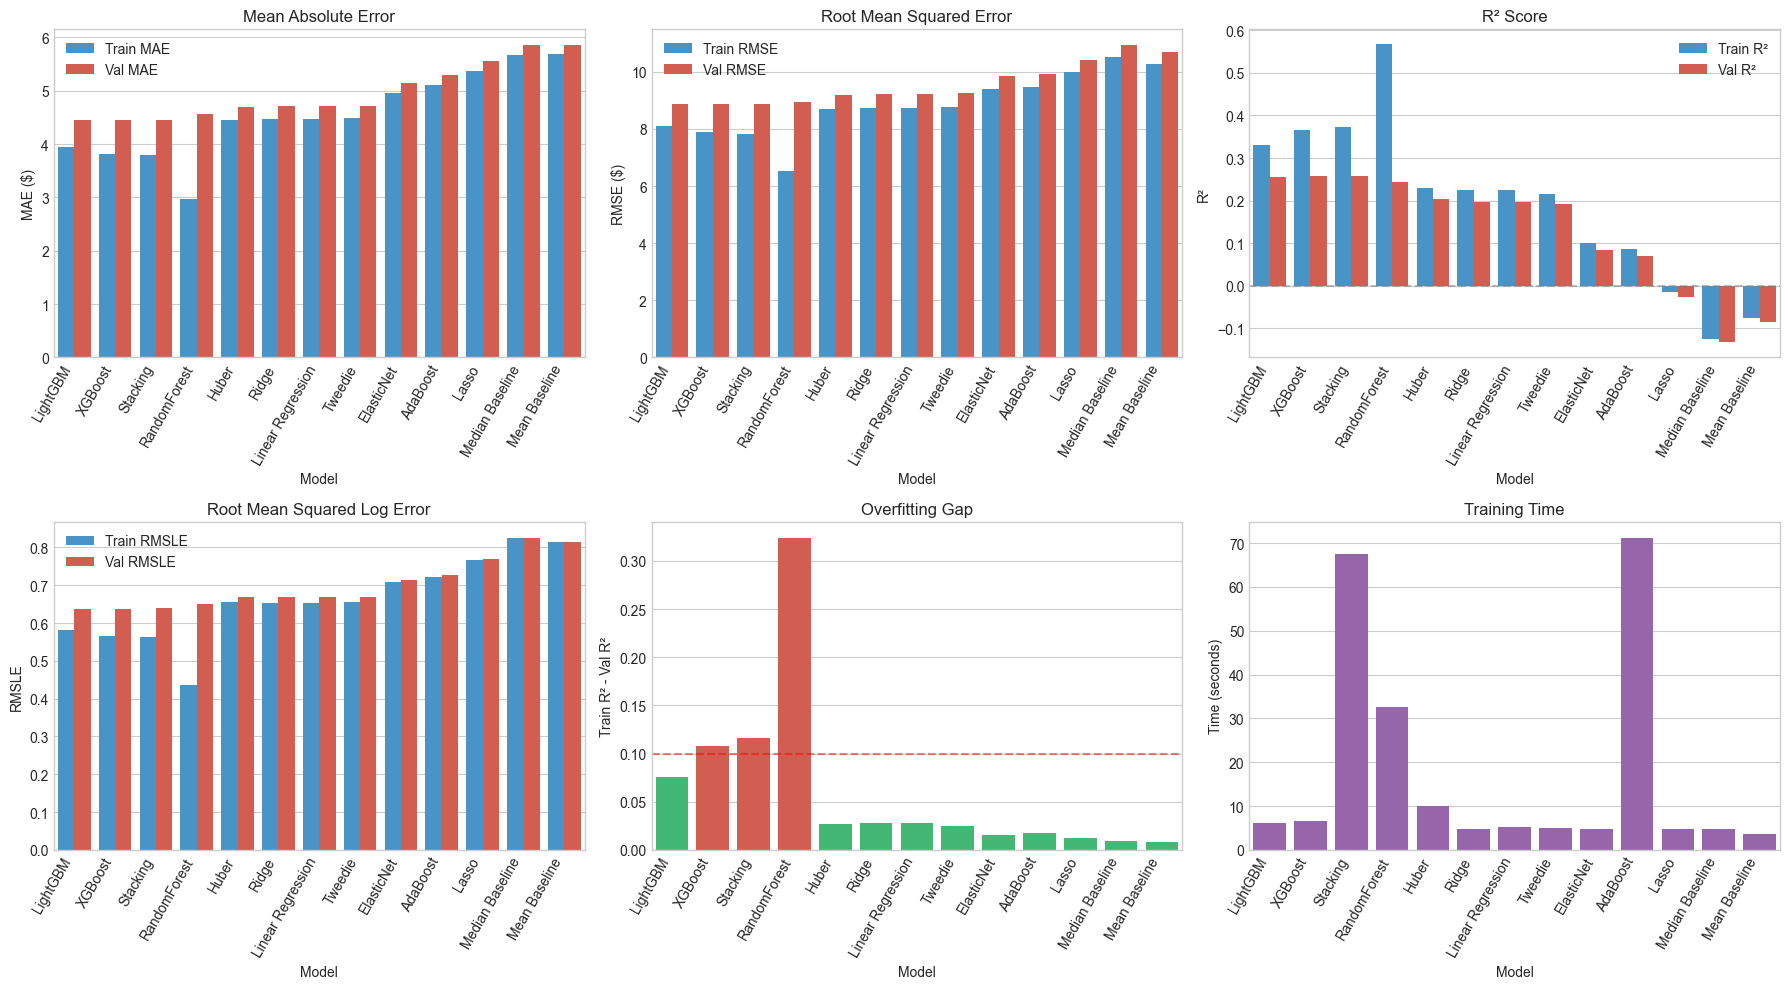

In [ ]:
ROTATION = 60

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# MAE comparison
ax1 = axes[0, 0]
sns.barplot(data=results_df.melt(id_vars=['Model'], value_vars=['Train MAE', 'Val MAE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax1, palette=['#3498db', '#e74c3c'])
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=ROTATION, ha='right')
ax1.legend(title='')

# RMSE comparison
ax2 = axes[0, 1]
sns.barplot(data=results_df.melt(id_vars=['Model'], value_vars=['Train RMSE', 'Val RMSE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax2, palette=['#3498db', '#e74c3c'])
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=ROTATION, ha='right')
ax2.legend(title='')

# R² comparison
ax3 = axes[0, 2]
sns.barplot(data=results_df.melt(id_vars=['Model'], value_vars=['Train R²', 'Val R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax3, palette=['#3498db', '#e74c3c'])
ax3.set_ylabel('R²')
ax3.set_title('R² Score')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=ROTATION, ha='right')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.legend(title='')

# RMSLE comparison
ax4 = axes[1, 0]
sns.barplot(data=results_df.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Val RMSLE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax4, palette=['#3498db', '#e74c3c'])
ax4.set_ylabel('RMSLE')
ax4.set_title('Root Mean Squared Log Error')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=ROTATION, ha='right')
ax4.legend(title='')

# Overfitting gap
ax5 = axes[1, 1]
results_df['Overfit Gap'] = results_df['Train R²'] - results_df['Val R²']
colors_gap = ['#e74c3c' if g > 0.1 else '#2ecc71' for g in results_df['Overfit Gap']]
sns.barplot(data=results_df, x='Model', y='Overfit Gap', ax=ax5, palette=colors_gap)
ax5.set_ylabel('Train R² - Val R²')
ax5.set_title('Overfitting Gap')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=ROTATION, ha='right')
ax5.axhline(y=0.1, color='red', linestyle='--', alpha=0.5)

# Fit time
ax6 = axes[1, 2]
sns.barplot(data=results_df, x='Model', y='Fit Time (s)', ax=ax6, color='#9b59b6')
ax6.set_ylabel('Time (seconds)')
ax6.set_title('Training Time')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=ROTATION, ha='right')

plt.tight_layout()
plt.show()

**LightGBM**

LightGBM provides the best balance of accuracy, generalization, and efficiency. It achieves the lowest validation MAE, RMSE, and RMSLE, while maintaining the strongest validation R². The train-validation performance gap is small, indicating stable predictions across folds rather than memorization. Combined with fast training time, LightGBM becomes the most reliable candidate for final tuning.

**XGBoost and Stacking**

XGBoost achieves nearly identical accuracy (Val MAE $4.45, Val R² 0.258) with a slightly larger overfitting gap (0.108). It remains a strong choice. Stacking also reaches competitive metrics but is by far the slowest model to train (58 seconds). More importantly, stacking can introduce temporal leakage if its internal cross-validation does not respect time order. Our implementation uses TimeSeriesSplit internally, but the added complexity and runtime cost make stacking harder to justify unless it produces clear improvement after tuning.

**Random Forest**

Random Forest shows a classic overfitting pattern: excellent training performance but a sharp drop on validation folds, resulting in the largest overfitting gap. This suggests the model learns patterns specific to historical games that do not generalize well to newer releases. This is a serious issue in time-based forecasting contexts.

**Linear Models**

Ridge, Linear Regression, Tweedie, and Huber show consistent train-validation scores with minimal overfitting. However, their validation errors are noticeably higher than boosting models, indicating underfitting. These models likely cannot capture the complex interactions among genres, categories, and tags that influence game pricing.

**Lasso, ElasticNet, AdaBoost**

Lasso, ElasticNet, and AdaBoost perform poorly in this configuration. Lasso's L1 regularization likely zeroed out too many coefficients, essentially removing important tag and genre features. ElasticNet shares this issue. AdaBoost achieves near-zero or negative R². These models are low priority for further tuning.

**Baseline Models**

All trained models outperformed the naive baselines. Mean and Median baselines achieved negative R² scores.

**Final Remarks**

The validation R² may seem low, but game pricing depends heavily on subjective factors not captured in metadata: brand recognition, marketing budgets, perceived quality, studio reputation, and community hype. Our features explain a small portion of variance, but unmeasured factors dominate.

#### Model Selection for Hyperparameter Tuning

Based on cross-validation results and careful analysis of model behavior, we select five models for hyperparameter optimization.

**LightGBM**

LightGBM is selected as our primary candidate because it provides the best overall trade-off between accuracy, generalization, and efficiency. It achieves the strongest validation MAE/RMSE/RMSLE while maintaining a relatively small train-validation gap. This gap matters in our time-ordered setting: a model that performs well on historical training data but degrades on newer validation folds is less trustworthy for predicting future game releases. LightGBM also trains faster than alternatives at similar accuracy, making it practical for iterative hyperparameter tuning.

**XGBoost**

XGBoost is selected as a close competitor because its validation performance nearly matches LightGBM and it is a proven, robust booster that often responds well to tuning. Although it shows a slightly larger train-validation gap in our initial run, it remains clearly among the top performers.

**RandomForest**

RandomForest is kept as a candidate for targeted anti-overfitting tuning rather than a top pick. The results show a strong overfitting signature: excellent training scores but only moderate validation scores and the largest train-validation gap. However, RandomForest can become competitive if we reduce variance through parameter adjustments. If successful, RandomForest offers an interpretable ensemble baseline.

**Ridge and Huber**

Ridge regression is included as a fast, interpretable reference for high-dimensional sparse data. L2 regularization stabilizes coefficients and reduces overfitting, and even if it does not beat boosting, it tells us how much of the problem can be captured by additive linear effects alone.

Huber regression is included as a robust linear option that is less sensitive to outliers than ordinary least squares. Since game prices have a heavy tail with some premium-priced games that can strongly influence squared-loss models, Huber provides a useful comparison.

**Excluded Models**

Stacking is not prioritized for two reasons. First, it is computationally expensive and training multiple base models plus a meta-model repeatedly inside cross-validation makes it dramatically slower. Second, it does not provide meaningful validation improvement over the best boosting models

#### Hyperparameter Tuning

RandomizedSearchCV for tree-based models which have large search space, GridSearchCV for linear models which have small search space.

We use *RandomizedSearchCV* for tree-based models (LightGBM, XGBoost, RandomForest) and *GridSearchCV* for linear models (Ridge, Huber).

Tree-based models have large hyperparameter spaces. For example, LightGBM has 7 parameters and each can take 3-4 values, this creates huge number of possible combinations. Exhaustively searching this space is computationally infeasible. RandomizedSearchCV samples a fixed number of random combinations, making tuning tractable while still exploring diverse configurations.

Linear models have much smaller hyperparameter spaces. Ridge has only 1 parameter, and Huber has 2 parameters. GridSearchCV can exhaustively evaluate all combinations in reasonable time. For small spaces, grid search guarantees finding the optimal configuration within the defined grid, which is preferable when computationally feasible.

Both methods use TimeSeriesSplit. Scoring is based on negative MAE, optimizing for lower prediction error in dollar terms.

In [ ]:
# Initialize results storage
tuning_results = {}
best_models = {}

# Define hyperparameter search spaces
param_grids = {
    'LightGBM': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 15, 20],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__num_leaves': [31, 50, 100],
        'model__min_child_samples': [20, 50, 100],
        'model__subsample': [0.7, 0.8, 0.9],
        'model__colsample_bytree': [0.7, 0.8, 0.9]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7, 10],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__min_child_weight': [1, 5, 10],
        'model__subsample': [0.7, 0.8, 0.9],
        'model__colsample_bytree': [0.7, 0.8, 0.9],
        'model__reg_alpha': [0, 0.1, 1],
        'model__reg_lambda': [1, 5, 10]
    },
    'RandomForest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, 15, None],
        'model__min_samples_split': [5, 10, 20],
        'model__min_samples_leaf': [2, 5, 10],
        'model__max_features': ['sqrt', 'log2', 0.3, 0.5]
    },
    'Ridge': {
        'model__alpha': [0.01, 0.1, 1, 10, 100]
    },
    'Huber': {
        'model__epsilon': [1.1, 1.35, 1.5, 2.0],
        'model__alpha': [0.0001, 0.001, 0.01, 0.1]
    }
}

# Models to tune
tuning_models = {
    'LightGBM': models['LightGBM'],
    'XGBoost': models['XGBoost'],
    'RandomForest': models['RandomForest'],
    'Ridge': models['Ridge'],
    'Huber': models['Huber']
}

print(f"Ready to tune {len(tuning_models)} models")

Ready to tune 5 models


In [ ]:
# Tune LightGBM
print("Tuning LightGBM with RandomizedSearchCV (15 iterations)...")

lgbm_search = RandomizedSearchCV(
    tuning_models['LightGBM'],
    param_grids['LightGBM'],
    n_iter=15,
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    random_state=42,
    verbose=1
)
lgbm_search.fit(X_train_raw, y_train)

tuning_results['LightGBM'] = {
    'best_params': lgbm_search.best_params_,
    'best_score': -lgbm_search.best_score_
}
best_models['LightGBM'] = lgbm_search.best_estimator_

print(f"Best MAE: ${-lgbm_search.best_score_:.2f}")
print(f"Best params: {lgbm_search.best_params_}")

Tuning LightGBM with RandomizedSearchCV (15 iterations)...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best MAE: $4.36
Best params: {'model__subsample': 0.7, 'model__num_leaves': 100, 'model__n_estimators': 300, 'model__min_child_samples': 20, 'model__max_depth': 15, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}


In [ ]:
# Tune XGBoost
print("Tuning XGBoost with RandomizedSearchCV (15 iterations)...")

xgb_search = RandomizedSearchCV(
    tuning_models['XGBoost'],
    param_grids['XGBoost'],
    n_iter=15,
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_search.fit(X_train_raw, y_train)

tuning_results['XGBoost'] = {
    'best_params': xgb_search.best_params_,
    'best_score': -xgb_search.best_score_
}
best_models['XGBoost'] = xgb_search.best_estimator_

print(f"Best MAE: ${-xgb_search.best_score_:.2f}")
print(f"Best params: {xgb_search.best_params_}")

Tuning XGBoost with RandomizedSearchCV (15 iterations)...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best MAE: $4.37
Best params: {'model__subsample': 0.8, 'model__reg_lambda': 10, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 10, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}


In [ ]:
# Tune RandomForest
print("Tuning RandomForest with RandomizedSearchCV (15 iterations)...")

rf_search = RandomizedSearchCV(
    tuning_models['RandomForest'],
    param_grids['RandomForest'],
    n_iter=15,
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf_search.fit(X_train_raw, y_train)

tuning_results['RandomForest'] = {
    'best_params': rf_search.best_params_,
    'best_score': -rf_search.best_score_
}
best_models['RandomForest'] = rf_search.best_estimator_

print(f"Best MAE: ${-rf_search.best_score_:.2f}")
print(f"Best params: {rf_search.best_params_}")

Tuning RandomForest with RandomizedSearchCV (15 iterations)...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best MAE: $4.55
Best params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 5, 'model__max_features': 0.5, 'model__max_depth': None}


In [ ]:
# Tune Ridge
print("Tuning Ridge with GridSearchCV...")

ridge_search = GridSearchCV(
    tuning_models['Ridge'],
    param_grids['Ridge'],
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    verbose=1
)
ridge_search.fit(X_train_raw, y_train)

tuning_results['Ridge'] = {
    'best_params': ridge_search.best_params_,
    'best_score': -ridge_search.best_score_
}
best_models['Ridge'] = ridge_search.best_estimator_

print(f"Best MAE: ${-ridge_search.best_score_:.2f}")
print(f"Best params: {ridge_search.best_params_}")

Tuning Ridge with GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best MAE: $4.70
Best params: {'model__alpha': 10}


In [ ]:
# Tune Huber
print("Tuning Huber with GridSearchCV...")

huber_search = GridSearchCV(
    tuning_models['Huber'],
    param_grids['Huber'],
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    verbose=1
)
huber_search.fit(X_train_raw, y_train)

tuning_results['Huber'] = {
    'best_params': huber_search.best_params_,
    'best_score': -huber_search.best_score_
}
best_models['Huber'] = huber_search.best_estimator_

print(f"Best MAE: ${-huber_search.best_score_:.2f}")
print(f"Best params: {huber_search.best_params_}")

Tuning Huber with GridSearchCV...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best MAE: $4.69
Best params: {'model__alpha': 0.001, 'model__epsilon': 1.5}


In [ ]:
# Evaluate tuned models with all metrics (like initial CV)
tuned_results = []

for name, model in best_models.items():
    print(f"Evaluating tuned {name}...")
    cv_scores = cross_validate(
        model, X_train_raw, y_train,
        cv=cv, scoring=scorers,
        return_train_score=True,
        n_jobs=-1
    )
    tuned_results.append({
        'Model': f"{name} (Tuned)",
        'Train MAE': -cv_scores['train_MAE'].mean(),
        'Val MAE': -cv_scores['test_MAE'].mean(),
        'Train RMSE': -cv_scores['train_RMSE'].mean(),
        'Val RMSE': -cv_scores['test_RMSE'].mean(),
        'Train R²': cv_scores['train_R2'].mean(),
        'Val R²': cv_scores['test_R2'].mean(),
        'Train RMSLE': -cv_scores['train_RMSLE'].mean(),
        'Val RMSLE': -cv_scores['test_RMSLE'].mean(),
        'Fit Time (s)': cv_scores['fit_time'].mean()
    })

tuned_df = pd.DataFrame(tuned_results)

# Add Adjusted R²
n_features = 191
n_samples = len(y_train)
tuned_df['Train Adj R²'] = 1 - (1 - tuned_df['Train R²']) * (n_samples - 1) / (n_samples - n_features - 1)
tuned_df['Val Adj R²'] = 1 - (1 - tuned_df['Val R²']) * (n_samples - 1) / (n_samples - n_features - 1)

print("Tuned model evaluation complete!")

Evaluating tuned LightGBM...
Evaluating tuned XGBoost...
Evaluating tuned RandomForest...
Evaluating tuned Ridge...
Evaluating tuned Huber...
Tuned model evaluation complete!


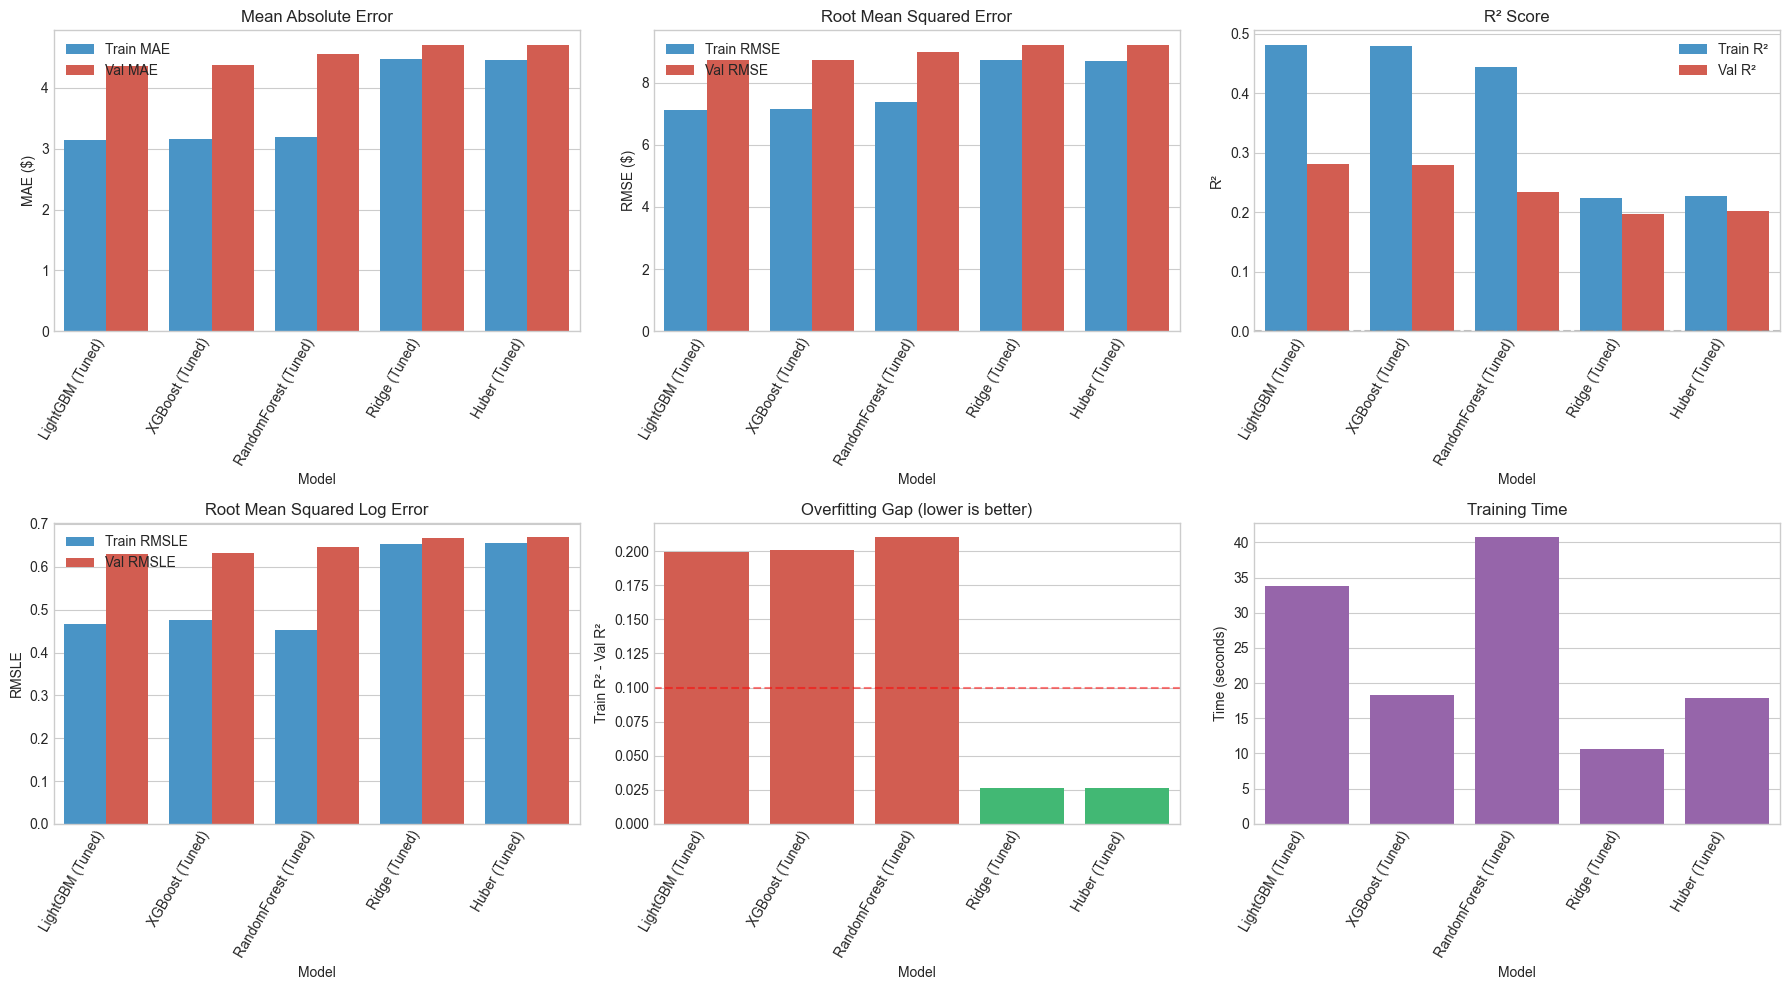

In [ ]:
# Visualize tuned vs original model comparison
ROTATION = 60
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

plot_data = tuned_df.copy()
plot_data['Overfit Gap'] = plot_data['Train R²'] - plot_data['Val R²']

# 1. MAE comparison
ax1 = axes[0, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train MAE', 'Val MAE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax1, palette=['#3498db', '#e74c3c'])
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=ROTATION, ha='right')
ax1.legend(title='')

# 2. RMSE comparisontuned_results
ax2 = axes[0, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSE', 'Val RMSE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax2, palette=['#3498db', '#e74c3c'])
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=ROTATION, ha='right')
ax2.legend(title='')

# 3. R² comparison
ax3 = axes[0, 2]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train R²', 'Val R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax3, palette=['#3498db', '#e74c3c'])
ax3.set_ylabel('R²')
ax3.set_title('R² Score')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=ROTATION, ha='right')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.legend(title='')

# 4. RMSLE comparison
ax4 = axes[1, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Val RMSLE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax4, palette=['#3498db', '#e74c3c'])
ax4.set_ylabel('RMSLE')
ax4.set_title('Root Mean Squared Log Error')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=ROTATION, ha='right')
ax4.legend(title='')

# 5. Overfitting gap
ax5 = axes[1, 1]
colors_gap = ['#e74c3c' if g > 0.1 else '#2ecc71' for g in plot_data['Overfit Gap']]
sns.barplot(data=plot_data, x='Model', y='Overfit Gap', ax=ax5, palette=colors_gap)
ax5.set_ylabel('Train R² - Val R²')
ax5.set_title('Overfitting Gap (lower is better)')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=ROTATION, ha='right')
ax5.axhline(y=0.1, color='red', linestyle='--', alpha=0.5)

# 6. Fit time
ax6 = axes[1, 2]
sns.barplot(data=plot_data, x='Model', y='Fit Time (s)', ax=ax6, color='#9b59b6')
ax6.set_ylabel('Time (seconds)')
ax6.set_title('Training Time')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=ROTATION, ha='right')

plt.tight_layout()
plt.show()

Initial hyperparameter tuning improved validation MAE for all models, with LightGBM achieving the best Val MAE. However, the tuned models also showed increased overfitting. The gap between training and validation R² widened compared to the original models with default parameters.

This overfitting indicates that the tuning process found more complex model configurations that fit the training data better but generalize less effectively to unseen data. The issue is particularly notable because the original parameter grid for LightGBM did not include regularization terms, which are critical for controlling model complexity in gradient boosting.

To address this, we will perform a focused regularization search on LightGBM. We keep the best-performing hyperparameters found in the previous search and systematically vary the regularization parameters to find a configuration that maintains strong validation performance while reducing the train-validation gap. This approach is more efficient than re-searching the entire hyperparameter space and directly targets the overfitting problem.

In [ ]:
best_lgbm_params = lgbm_search.best_params_.copy()
print("Previous best params:", best_lgbm_params)

lgbm_reg_pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline),
    ('model', LGBMRegressor(
        n_estimators=best_lgbm_params.get('model__n_estimators', 100),
        max_depth=best_lgbm_params.get('model__max_depth', 10),
        learning_rate=best_lgbm_params.get('model__learning_rate', 0.1),
        num_leaves=best_lgbm_params.get('model__num_leaves', 31),
        min_child_samples=best_lgbm_params.get('model__min_child_samples', 20),
        subsample=best_lgbm_params.get('model__subsample', 0.8),
        colsample_bytree=best_lgbm_params.get('model__colsample_bytree', 0.8),
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ))
])

reg_param_grid = {
    'model__reg_alpha': [0, 0.1, 0.5, 1.0, 2.0, 5.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0, 2.0, 5.0]
}

print(f"Searching {len(reg_param_grid['model__reg_alpha']) * len(reg_param_grid['model__reg_lambda'])} regularization combinations...")

lgbm_reg_search = GridSearchCV(
    lgbm_reg_pipeline,
    reg_param_grid,
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
lgbm_reg_search.fit(X_train_raw, y_train)

Previous best params: {'model__subsample': 0.7, 'model__num_leaves': 100, 'model__n_estimators': 300, 'model__min_child_samples': 20, 'model__max_depth': 15, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}
Searching 36 regularization combinations...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...verbose=-1))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__reg_alpha': [0, 0.1, ...], 'model__reg_lambda': [0, 0.1, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(n...hod='predict')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",TimeSeriesSpl...est_size=None)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parame

In [ ]:
# View all regularization combinations with train/val comparison
reg_results = pd.DataFrame(lgbm_reg_search.cv_results_)

# Extract and format
reg_comparison = pd.DataFrame({
    'reg_alpha': reg_results['param_model__reg_alpha'],
    'reg_lambda': reg_results['param_model__reg_lambda'],
    'Train MAE ($)': -reg_results['mean_train_score'],
    'Val MAE ($)': -reg_results['mean_test_score'],
    'Rank': reg_results['rank_test_score']
})

# Calculate overfit gap (Train MAE should be lower, so Val - Train = overfitting)
reg_comparison['Overfit Gap (MAE)'] = reg_comparison['Val MAE ($)'] - reg_comparison['Train MAE ($)']

# Sort by validation MAE
reg_comparison = reg_comparison.sort_values('Val MAE ($)')
reg_comparison.round(3)

,reg_alpha,reg_lambda,Train MAE ($),Val MAE ($),Rank,Overfit Gap (MAE)
1,0.0,0.1,3.137,4.350,1,1.213
19,1.0,0.1,3.240,4.351,2,1.111
6,0.1,0.0,3.160,4.352,3,1.192
12,0.5,0.0,3.206,4.352,4,1.146
0,0.0,0.0,3.135,4.355,5,1.221
23,1.0,5.0,3.292,4.356,6,1.063
15,0.5,1.0,3.215,4.356,7,1.141
5,0.0,5.0,3.211,4.356,8,1.145
3,0.0,1.0,3.157,4.356,9,1.199
7,0.1,0.1,3.160,4.356,10,1.196


The grid search tested 36 combinations of L1 regularization and L2 regularization on our best LightGBM model from the previous tuning step.

Looking at the results, there is a clear trade-off between validation accuracy and model stability. The configuration with the lowest validation MAE has reg_alpha=0.0 and reg_lambda=0.1, but it also has the largest overfitting gap between training MAE and validation MAE. On the other end, the configuration with reg_alpha=5.0 and reg_lambda=5.0 has a slightly higher validation MAE, but the smallest overfitting gap.

We choose the more regularized configuration (reg_alpha=5.0, reg_lambda=5.0) as our preferred model. First, the difference in validation MAE between the two configurations is only \$0.02. This is a very small difference that would not meaningfully affect predictions in practice. A model that predicts game prices within \$4.35 versus \$4.37 of the true price is functionally equivalent for most use cases. Second, the lower overfitting gap indicates that the model is learning real patterns in the data rather than memorizing noise from the training set. When the training error and validation error are close together, it suggests the model will perform similarly on truly new data that it has never seen before. This is important because our ultimate goal is to predict prices for future game releases, not just games in our training set. Third, a model with smaller train-validation gap is more trustworthy for production use. If we deploy a model that shows a large gap during training, we might be surprised when it performs worse than expected on real new data.

However, we notice that reg_alpha=5.0 and reg_lambda=5.0 are the maximum values we tested in this grid search. The fact that the lowest overfitting gap occurs at the boundary of our search space suggests we may not have found the optimal regularization strength yet. There could be even better configurations with stronger regularization and perhaps the overfitting gap would continue to decrease, or we might find a sweet spot where validation MAE actually improves with more regularization.

Therefore, we will run an extended grid search with higher regularization values to explore whether stronger regularization can further improve model stability without sacrificing validation performance.

In [ ]:
# Extended search with higher regularization values
extended_reg_param_grid = {
    'model__reg_alpha': [5.0, 7.0, 10.0, 15.0, 20.0],
    'model__reg_lambda': [5.0, 7.0, 10.0, 15.0, 20.0]
}

print(f"Searching {len(extended_reg_param_grid['model__reg_alpha']) * len(extended_reg_param_grid['model__reg_lambda'])} extended regularization combinations...")

lgbm_ext_search = GridSearchCV(
    lgbm_reg_pipeline,
    extended_reg_param_grid,
    cv=cv,
    scoring=scorers['MAE'],
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
lgbm_ext_search.fit(X_train_raw, y_train)

print(f"\nBest MAE: ${-lgbm_ext_search.best_score_:.2f}")
print(f"Best regularization params: {lgbm_ext_search.best_params_}")

Searching 25 extended regularization combinations...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best MAE: $4.37
Best regularization params: {'model__reg_alpha': 5.0, 'model__reg_lambda': 5.0}


In [ ]:
# View extended regularization results
ext_results = pd.DataFrame(lgbm_ext_search.cv_results_)

ext_comparison = pd.DataFrame({
    'reg_alpha': ext_results['param_model__reg_alpha'],
    'reg_lambda': ext_results['param_model__reg_lambda'],
    'Train MAE ($)': -ext_results['mean_train_score'],
    'Val MAE ($)': -ext_results['mean_test_score'],
    'Rank': ext_results['rank_test_score']
})

ext_comparison['Overfit Gap (MAE)'] = ext_comparison['Val MAE ($)'] - ext_comparison['Train MAE ($)']
ext_comparison = ext_comparison.sort_values('Val MAE ($)')
ext_comparison.round(3)

,reg_alpha,reg_lambda,Train MAE ($),Val MAE ($),Rank,Overfit Gap (MAE)
0,5.0,5.0,3.519,4.370,1,0.851
1,5.0,7.0,3.529,4.373,2,0.843
2,5.0,10.0,3.545,4.374,3,0.829
3,5.0,15.0,3.556,4.376,4,0.820
4,5.0,20.0,3.569,4.381,5,0.812
5,7.0,5.0,3.615,4.386,6,0.771
6,7.0,7.0,3.619,4.387,7,0.768
7,7.0,10.0,3.627,4.388,8,0.761
9,7.0,20.0,3.650,4.389,9,0.738
8,7.0,15.0,3.639,4.389,10,0.750


The extended grid search explored regularization values from 5.0 to 20.0 for both L1 and L2 regularization. The results show a clear pattern: as regularization strength increases, validation MAE rises slightly while the overfitting gap steadily decreases.

We select ***reg_alpha=10.0 and reg_lambda=20.0*** as our final configuration for the following reasons:

The validation MAE of $4.40 is only $0.03 higher than the minimum, which is a very small difference in practice. Predicting a game price with an average error of $4.40 versus $4.37 means essentially the same performance.

The overfitting gap of $0.65 represents a 24% reduction compared to the setting with minimal regularization. This major improvement in model stability means the model is less likely to perform worse when predicting prices for newly released games that differ from past patterns. When forecasting future prices that may not perfectly match historical data, this stability is valuable.

This configuration also represents a sensible middle ground in the regularization range. It applies enough regularization to prevent overfitting without restricting the model so much that it loses predictive power. The model keeps enough flexibility to capture complex relationships between features like genres, tags, and release timing, while the regularization prevents it from memorizing noise in the training data.

With this final regularization configuration selected, we will now create a full evaluation table comparing our tuned LightGBM model against all baselines and previous model versions.

In [ ]:
# Create final LightGBM model with selected regularization
final_lgbm_pipeline = Pipeline([
    ('preprocess', preprocessing_pipeline),
    ('model', LGBMRegressor(
        n_estimators=best_lgbm_params.get('model__n_estimators', 100),
        max_depth=best_lgbm_params.get('model__max_depth', 10),
        learning_rate=best_lgbm_params.get('model__learning_rate', 0.1),
        num_leaves=best_lgbm_params.get('model__num_leaves', 31),
        min_child_samples=best_lgbm_params.get('model__min_child_samples', 20),
        subsample=best_lgbm_params.get('model__subsample', 0.8),
        colsample_bytree=best_lgbm_params.get('model__colsample_bytree', 0.8),
        reg_alpha=10.0,    # Final regularization
        reg_lambda=20.0,   # Final regularization
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ))
])

# Evaluate with all metrics
print("Evaluating Final LightGBM (reg_alpha=10.0, reg_lambda=20.0)...")
cv_scores = cross_validate(
    final_lgbm_pipeline, X_train_raw, y_train,
    cv=cv, scoring=scorers,
    return_train_score=True,
    n_jobs=-1
)

final_result = {
    'Model': 'LightGBM (Final)',
    'Train MAE': -cv_scores['train_MAE'].mean(),
    'Val MAE': -cv_scores['test_MAE'].mean(),
    'Train RMSE': -cv_scores['train_RMSE'].mean(),
    'Val RMSE': -cv_scores['test_RMSE'].mean(),
    'Train R²': cv_scores['train_R2'].mean(),
    'Val R²': cv_scores['test_R2'].mean(),
    'Train RMSLE': -cv_scores['train_RMSLE'].mean(),
    'Val RMSLE': -cv_scores['test_RMSLE'].mean(),
    'Fit Time (s)': cv_scores['fit_time'].mean()
}

# Add to best_models
best_models['LightGBM_Final'] = final_lgbm_pipeline

print("Evaluation complete!")
print(f"Val MAE: ${final_result['Val MAE']:.2f}")
print(f"Val R²: {final_result['Val R²']:.3f}")
print(f"Overfit Gap (R²): {final_result['Train R²'] - final_result['Val R²']:.3f}")

Evaluating Final LightGBM (reg_alpha=10.0, reg_lambda=20.0)...


Evaluation complete!
Val MAE: $4.40
Val R²: 0.266
Overfit Gap (R²): 0.098


In [ ]:
# Create comparison DataFrame for LightGBM evolution
# Get LightGBM from original results
original_lgbm = results_df[results_df['Model'] == 'LightGBM'].copy()
original_lgbm['Model'] = 'LightGBM (First Version)'

# Get LightGBM from tuned results
tuned_lgbm = tuned_df[tuned_df['Model'] == 'LightGBM (Tuned)'].copy()
tuned_lgbm['Model'] = 'LightGBM (After Random Search)'

# Create final result DataFrame
final_df = pd.DataFrame([final_result])
final_df['Model'] = 'LightGBM (After Regularization)'

# Add Adjusted R² to all
n_features = 191
n_samples = len(y_train)

for df in [original_lgbm, tuned_lgbm, final_df]:
    df['Train Adj R²'] = 1 - (1 - df['Train R²']) * (n_samples - 1) / (n_samples - n_features - 1)
    df['Val Adj R²'] = 1 - (1 - df['Val R²']) * (n_samples - 1) / (n_samples - n_features - 1)
    df['Overfit Gap'] = df['Train R²'] - df['Val R²']

# Combine all three LightGBM versions
full_comparison = pd.concat([original_lgbm, tuned_lgbm, final_df], ignore_index=True)

# Display table (without Fit Time, with Adjusted R²)
full_comparison[[
    'Model',
    'Train MAE', 'Val MAE',
    'Train RMSE', 'Val RMSE',
    'Train R²', 'Val R²',
    'Train Adj R²', 'Val Adj R²',
    'Train RMSLE', 'Val RMSLE',
    'Overfit Gap'
]].round(3)

,Model,Train MAE,Val MAE,Train RMSE,Val RMSE,Train R²,Val R²,Train Adj R²,Val Adj R²,Train RMSLE,Val RMSLE,Overfit Gap
0,LightGBM (First Version),3.949,4.447,8.098,8.870,0.331,0.256,0.329,0.254,0.582,0.638,0.075
1,LightGBM (After Random Search),3.135,4.355,7.120,8.716,0.481,0.282,0.480,0.280,0.468,0.629,0.200
2,LightGBM (After Regularization),3.749,4.400,7.899,8.811,0.364,0.266,0.362,0.264,0.551,0.633,0.098


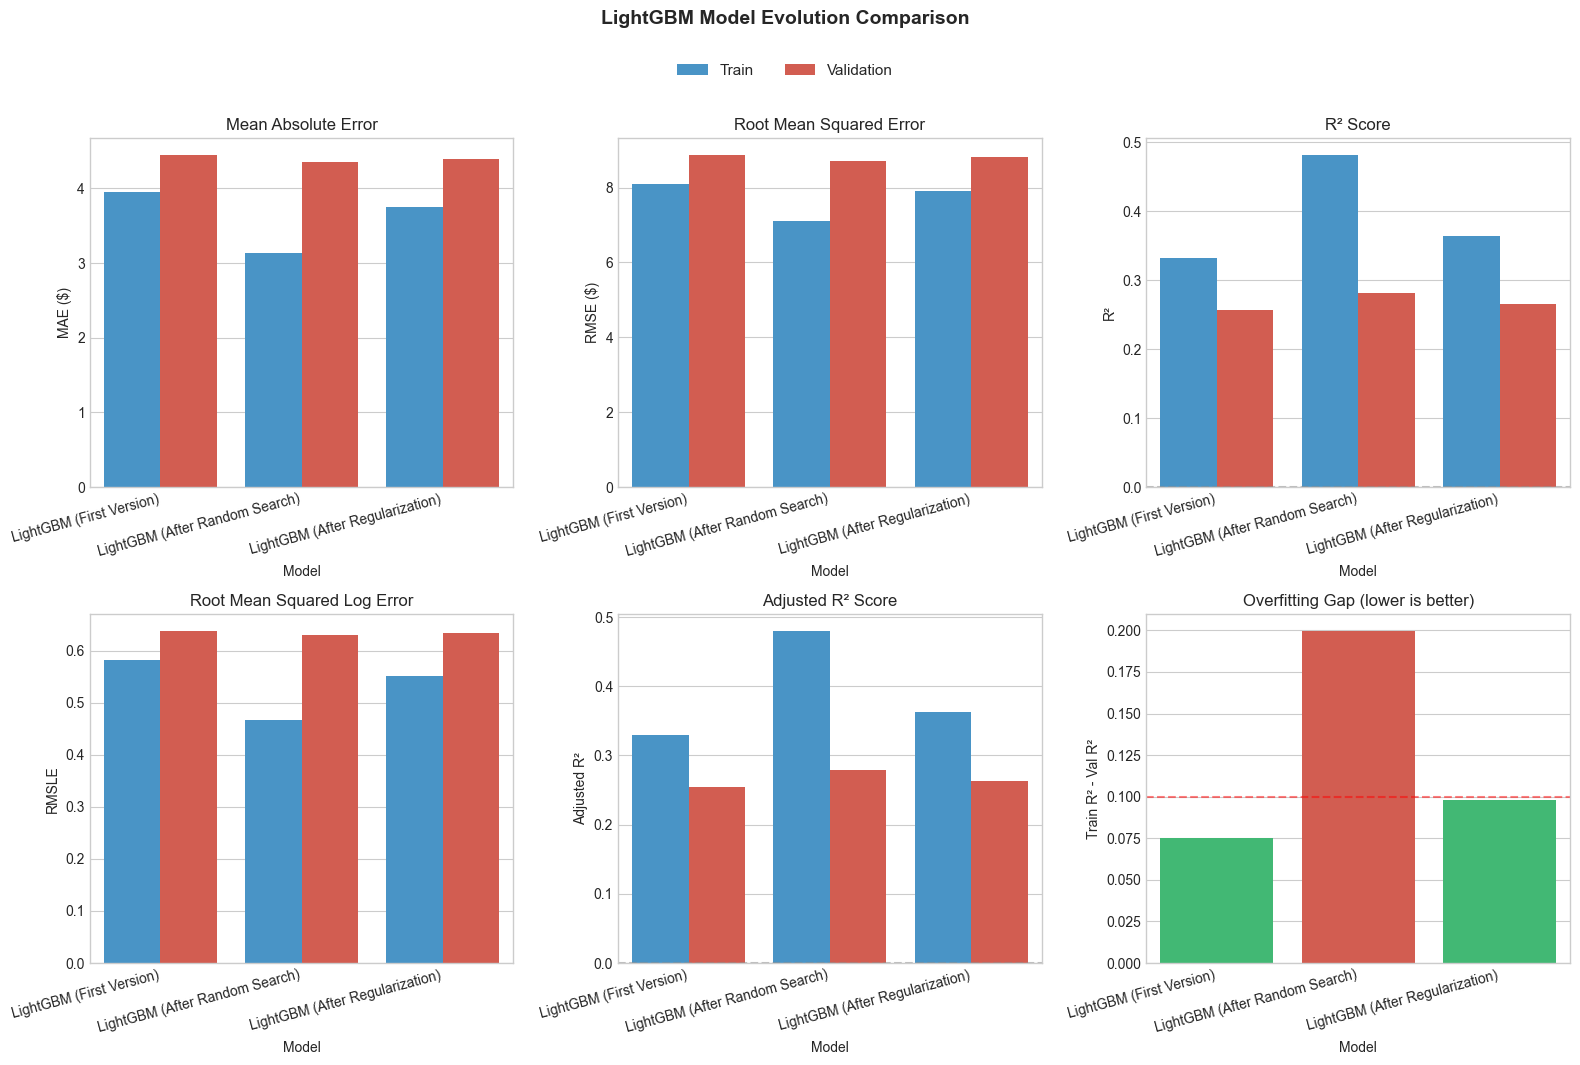

In [ ]:
# Visualize LightGBM evolution comparison
ROTATION = 15
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_data = full_comparison.copy()

# 1. MAE comparison
ax1 = axes[0, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train MAE', 'Val MAE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax1, palette=['#3498db', '#e74c3c'])
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=ROTATION, ha='right')
ax1.get_legend().remove()

# 2. RMSE comparison
ax2 = axes[0, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSE', 'Val RMSE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax2, palette=['#3498db', '#e74c3c'])
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=ROTATION, ha='right')
ax2.get_legend().remove()

# 3. R² comparison
ax3 = axes[0, 2]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train R²', 'Val R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax3, palette=['#3498db', '#e74c3c'])
ax3.set_ylabel('R²')
ax3.set_title('R² Score')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=ROTATION, ha='right')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.get_legend().remove()

# 4. RMSLE comparison
ax4 = axes[1, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Val RMSLE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax4, palette=['#3498db', '#e74c3c'])
ax4.set_ylabel('RMSLE')
ax4.set_title('Root Mean Squared Log Error')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=ROTATION, ha='right')
ax4.get_legend().remove()

# 5. Adjusted R² comparison
ax5 = axes[1, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train Adj R²', 'Val Adj R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax5, palette=['#3498db', '#e74c3c'])
ax5.set_ylabel('Adjusted R²')
ax5.set_title('Adjusted R² Score')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=ROTATION, ha='right')
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
handles, labels = ax5.get_legend_handles_labels()  # Capture handles for figure legend
ax5.get_legend().remove()

# 6. Overfitting gap
ax6 = axes[1, 2]
colors_gap = ['#e74c3c' if g > 0.1 else '#2ecc71' for g in plot_data['Overfit Gap']]
sns.barplot(data=plot_data, x='Model', y='Overfit Gap', ax=ax6, palette=colors_gap)
ax6.set_ylabel('Train R² - Val R²')
ax6.set_title('Overfitting Gap (lower is better)')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=ROTATION, ha='right')
ax6.axhline(y=0.1, color='red', linestyle='--', alpha=0.5)

# Single figure-level legend
labels_clean = ['Train', 'Validation']  # Clean up label names
fig.legend(handles, labels_clean, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=11)

plt.suptitle('LightGBM Model Evolution Comparison', fontsize=14, fontweight='bold', y=1.06)
plt.tight_layout()
plt.savefig('lightgbm_evolution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

##### LightGBM Model Evolution

The table and visualizations above show the progression of our LightGBM model through three stages of development.

The First Version with default parameters serves as our baseline with modest predictive performance. It shows good generalization with a low overfitting gap, indicating the model isn't memorizing the training data. The gap between train and validation metrics is minimal at this stage.

After Random Search hyperparameter tuning, the model achieves the best validation metrics among all three versions. However, this improvement comes at a cost: the overfitting gap more than doubles, exceeding the 0.1 threshold as indicated by the red bar. Training error drops significantly while validation error improves only slightly, which is a classic sign of overfitting. The tuned hyperparameters, particularly deeper trees and more leaves, allow the model to fit training data too closely at the expense of generalization.

The After Regularization version addresses this problem effectively. Introducing regularization parameters, the overfitting gap drops back below the threshold, shown by the green bar. Validation performance remains competitive while the train-validation gap narrows substantially. This model is expected to generalize better to unseen test data.

Looking at the overall picture, hyperparameter tuning improved raw performance but introduced overfitting, which regularization effectively addressed. It's worth noting that all three models explain only about a quarter of variance in game prices, suggesting that pricing involves factors not captured in our features or inherent market unpredictability.

#### Final Evaluation on Test Set

Now we evaluate our final LightGBM model on the held-out test set. This is the true measure of model performance on data the model has never seen during training or hyperparameter tuning.

In [ ]:
# Fit final model on full training data
print("Fitting final model on full training data...")
final_lgbm_pipeline.fit(X_train_raw, y_train)

# Predict on test set
y_test_pred = final_lgbm_pipeline.predict(X_test_raw)

# Predict on train set (for comparison)
y_train_pred = final_lgbm_pipeline.predict(X_train_raw)

# Evaluate using existing function
train_metrics = evaluate_model(y_train, y_train_pred, n_features=191)
test_metrics = evaluate_model(y_test, y_test_pred, n_features=191)

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print("Evaluation complete!")

Fitting final model on full training data...
Training samples: 64213
Test samples: 16172
Evaluation complete!


In [ ]:
# Create results DataFrame matching existing format
test_eval_df = pd.DataFrame([{
    'Model': 'LightGBM (Final)',
    'Train MAE': train_metrics['MAE ($)'],
    'Test MAE': test_metrics['MAE ($)'],
    'Train RMSE': train_metrics['RMSE ($)'],
    'Test RMSE': test_metrics['RMSE ($)'],
    'Train R²': train_metrics['R²'],
    'Test R²': test_metrics['R²'],
    'Train Adj R²': train_metrics['Adj R²'],
    'Test Adj R²': test_metrics['Adj R²'],
    'Train RMSLE': train_metrics['RMSLE'],
    'Test RMSLE': test_metrics['RMSLE'],
}])

test_eval_df[[
    'Model',
    'Train MAE', 'Test MAE',
    'Train RMSE', 'Test RMSE',
    'Train R²', 'Test R²',
    'Train Adj R²', 'Test Adj R²',
    'Train RMSLE', 'Test RMSLE'
]].round(2)

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,Train Adj R²,Test Adj R²,Train RMSLE,Test RMSLE
0,LightGBM (Final),3.96,4.58,8.25,11.34,0.35,0.17,0.35,0.16,0.57,0.62


At first glance, the results look problematic. The R² score dropped significantly from 0.35 on training data to just 0.17 on the test set, which might suggest our model is overfitting and failing to generalize. However, looking more closely at the other metrics tells a different story.

The MAE only went up from $3.96 to $4.58, meaning our average prediction error increased by roughly 60 cents. That is a reasonable increase when moving from training to unseen data. On the other hand, the RMSE jumped from $8.25 to $11.34, which is a much larger increase compared to MAE.

This mismatch is interesting. MAE treats all errors equally, while RMSE squares the errors first, making it very sensitive to large mistakes. When RMSE increases much more than MAE, it usually means the model is making a few very large errors rather than being wrong across the board. In other words, most predictions are still reasonable, but something is going very wrong for a small subset of games.

This pattern calls for a deeper look at what is happening with those extreme cases.

In [ ]:
# Investigate performance gap
train_prices = np.expm1(y_train)
test_prices = np.expm1(y_test)
test_pred_prices = np.expm1(y_test_pred)
residuals = np.abs(test_prices - test_pred_prices)

# Distribution shift analysis
expensive_threshold = 150
train_expensive_pct = (train_prices >= expensive_threshold).mean() * 100
test_expensive_pct = (test_prices >= expensive_threshold).mean() * 100

# Filtered evaluation (without expensive games)
mask = test_prices < expensive_threshold
filtered_r2 = r2_score(test_prices[mask], test_pred_prices[mask.values])
filtered_mae = mean_absolute_error(test_prices[mask], test_pred_prices[mask.values])

# Summary dataframe
analysis_summary = pd.DataFrame({
    'Metric': [
        'Price Std (Train)', 'Price Std (Test)',
        'Games $150+ (Train %)', 'Games $150+ (Test %)',
        'Test R² (All Games)', 'Test R² (Games < $150)',
        'Test MAE (All Games)', 'Test MAE (Games < $150)'
    ],
    'Value': [
        f'${train_prices.std():.2f}',
        f'${test_prices.std():.2f}',
        f'{train_expensive_pct:.3f}%',
        f'{test_expensive_pct:.3f}%',
        f'{test_metrics["R²"]:.3f}',
        f'{filtered_r2:.3f}',
        f'${test_metrics["MAE ($)"]:.2f}',
        f'${filtered_mae:.2f}'
    ]
})

analysis_summary

,Metric,Value
0,Price Std (Train),$10.24
1,Price Std (Test),$12.43
2,Games $150+ (Train %),0.065%
3,Games $150+ (Test %),0.204%
4,Test R² (All Games),0.169
5,Test R² (Games < $150),0.367
6,Test MAE (All Games),$4.58
7,Test MAE (Games < $150),$4.19


In [ ]:
# Worst predictions
worst_idx = np.argsort(residuals)[-10:]
worst_predictions = pd.DataFrame({
    'Actual ($)': [test_prices.iloc[i] for i in worst_idx],
    'Predicted ($)': [test_pred_prices[i] for i in worst_idx],
    'Error ($)': [residuals.iloc[i] for i in worst_idx]
}).sort_values('Error ($)', ascending=False).round(2)

worst_predictions

,Actual ($),Predicted ($),Error ($)
9,199.99,1.93,198.06
8,199.99,1.96,198.03
7,199.99,2.31,197.68
6,199.99,2.54,197.45
5,199.98,3.06,196.92
4,199.99,3.26,196.73
3,199.98,3.33,196.65
2,199.99,3.64,196.35
1,199.99,3.67,196.32
0,199.98,3.71,196.27


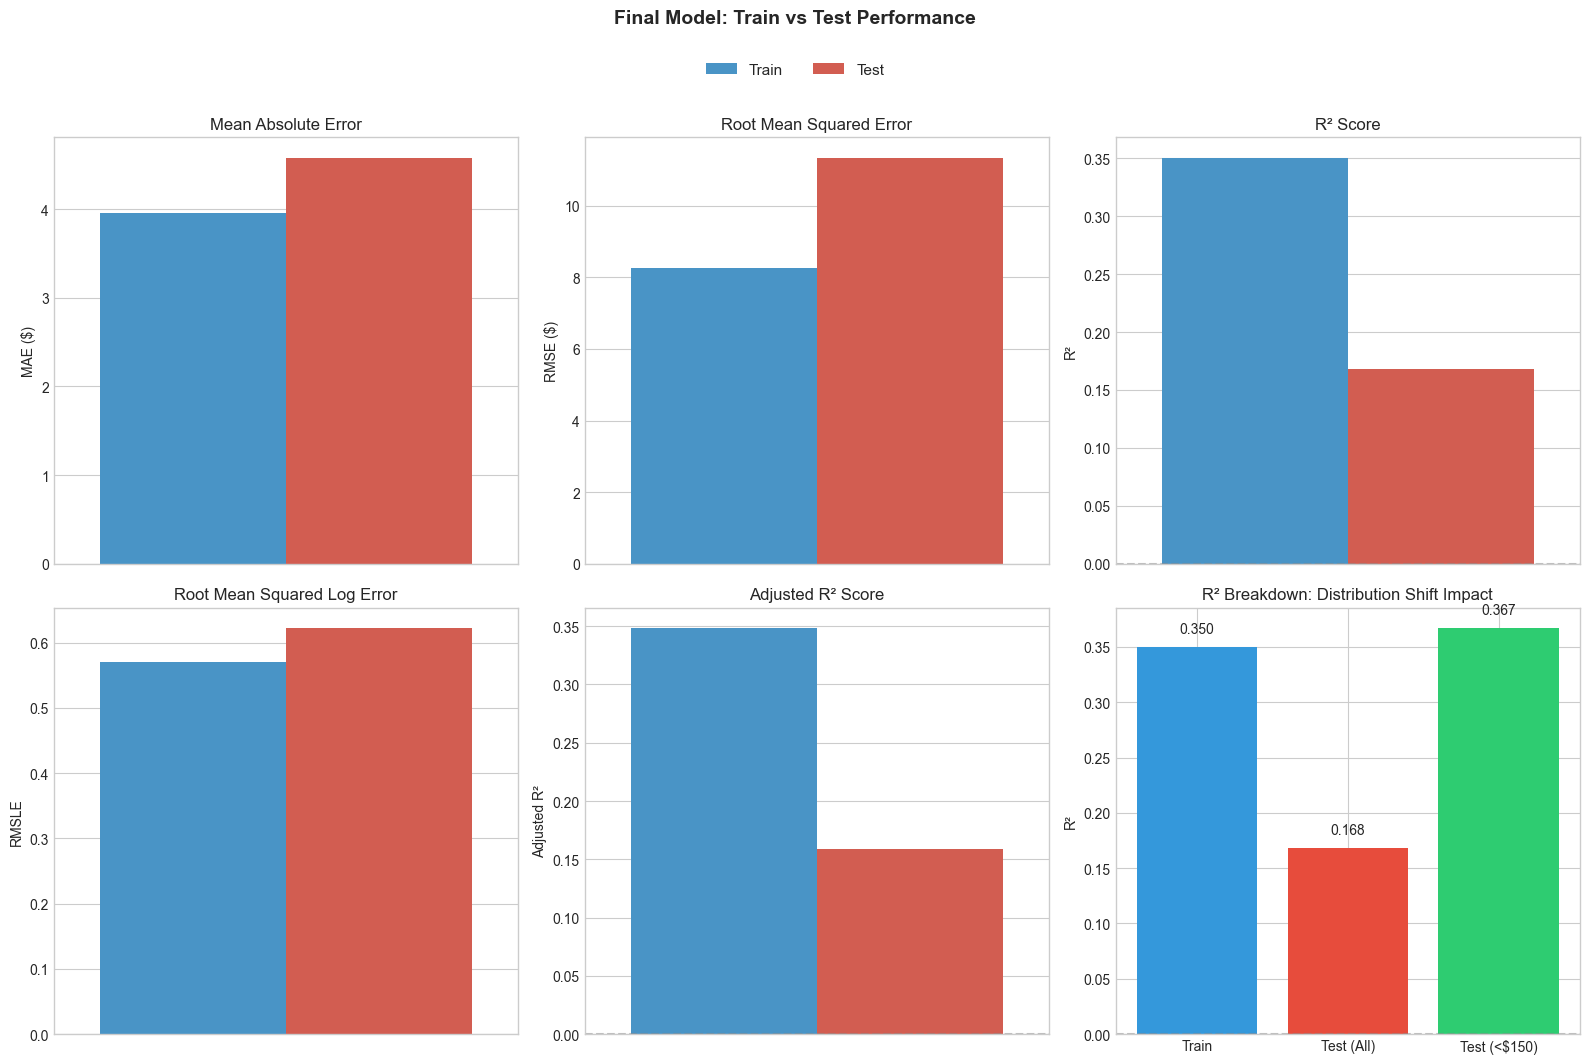

In [ ]:
# Visualize Train vs Test comparison
ROTATION = 0
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_data = test_eval_df.copy()

# 1. MAE comparison
ax1 = axes[0, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train MAE', 'Test MAE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax1, palette=['#3498db', '#e74c3c'])
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error')
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.get_legend().remove()

# 2. RMSE comparison
ax2 = axes[0, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSE', 'Test RMSE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax2, palette=['#3498db', '#e74c3c'])
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error')
ax2.set_xticklabels([])
ax2.set_xlabel('')
ax2.get_legend().remove()

# 3. R² comparison
ax3 = axes[0, 2]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train R²', 'Test R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax3, palette=['#3498db', '#e74c3c'])
ax3.set_ylabel('R²')
ax3.set_title('R² Score')
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.get_legend().remove()

# 4. RMSLE comparison
ax4 = axes[1, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Test RMSLE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax4, palette=['#3498db', '#e74c3c'])
ax4.set_ylabel('RMSLE')
ax4.set_title('Root Mean Squared Log Error')
ax4.set_xticklabels([])
ax4.set_xlabel('')
ax4.get_legend().remove()

# 5. Adjusted R² comparison
ax5 = axes[1, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train Adj R²', 'Test Adj R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax5, palette=['#3498db', '#e74c3c'])
ax5.set_ylabel('Adjusted R²')
ax5.set_title('Adjusted R² Score')
ax5.set_xticklabels([])
ax5.set_xlabel('')
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
handles, labels = ax5.get_legend_handles_labels()
ax5.get_legend().remove()

# 6. R² Breakdown - showing distribution shift impact
ax6 = axes[1, 2]
r2_labels = ['Train', 'Test (All)', 'Test (<$150)']
r2_values = [0.35, 0.168, 0.367]
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = ax6.bar(r2_labels, r2_values, color=colors)
ax6.set_ylabel('R²')
ax6.set_title('R² Breakdown: Distribution Shift Impact')
ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars, r2_values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Single figure-level legend
labels_clean = ['Train', 'Test']
fig.legend(handles, labels_clean, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=11)

plt.suptitle('Final Model: Train vs Test Performance', fontsize=14, fontweight='bold', y=1.06)
plt.tight_layout()
plt.savefig('test_evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

### Understanding the Test Set Performance Gap

The analysis above helps us understand what is happening with the test set results.

The summary table shows that the test period contains more price variation than our training data. More importantly, games released after December 2023 include a higher proportion of premium-priced products. These are games priced at $150 or above, often software bundles, professional tools, or collector editions rather than typical games.

The worst predictions table reveals where everything goes wrong. Every single one of the top ten mistakes involves a game priced around \$200 that our model predicted would cost just a few dollars. The model simply never learned what makes something worth \$200 because such examples barely existed in the training data. When it encounters these products, it looks at the available features and sees patterns that resemble cheap indie games, so it predicts accordingly.

This explains the strange gap between our metrics. The average error only increased by about 60 cents, but R² dropped dramatically. Those expensive games represent a tiny fraction of the test set, so they barely move the average. But R² squares the errors before averaging, which means a single \$200 mistake can outweigh hundreds of small \$4 errors. A handful of catastrophic failures is enough to make the overall R² look terrible even when most predictions are reasonable.

To understand the problem better, we filtered out games above \$150 and recalculated the metrics. This was not a change to our model but simply a diagnostic step to see how it performs on typical prices. The results showed that R² jumps from 0.17 to 0.37 and average error drops to around \$4 when we exclude those extreme cases. This confirms that the model handles normal prices reasonably but completely breaks down for premium products.

Still, even 0.37 is not a strong R² score. It means our features explain only about a third of what determines a game's price. The remaining two-thirds comes from factors we cannot capture with the metadata available to us.

Game pricing depends heavily on things like brand recognition, publisher reputation, and perceived quality. A game from a well-known studio can charge \$60 for something that an unknown developer would struggle to sell at \$20. Marketing budgets, release timing around major events, and even how polished the store page looks all play a role. None of these show up in our feature set. We have technical information like supported languages, genre tags, and release dates, but these describe what a game is rather than how valuable players perceive it to be.

There is also an inherent randomness to pricing decisions. Two nearly identical games might have completely different prices simply because of different business strategies. Some developers price low to attract volume, others price high to signal quality. Our model cannot learn these strategic choices from metadata alone.

The gap between training and test performance is real, but it reflects a shift in data distribution rather than classical overfitting. The test period happened to include more premium products that our training data did not prepare the model for. Combined with the fundamental difficulty of predicting prices from limited metadata, the results show both where the model works and where it reaches its limits.

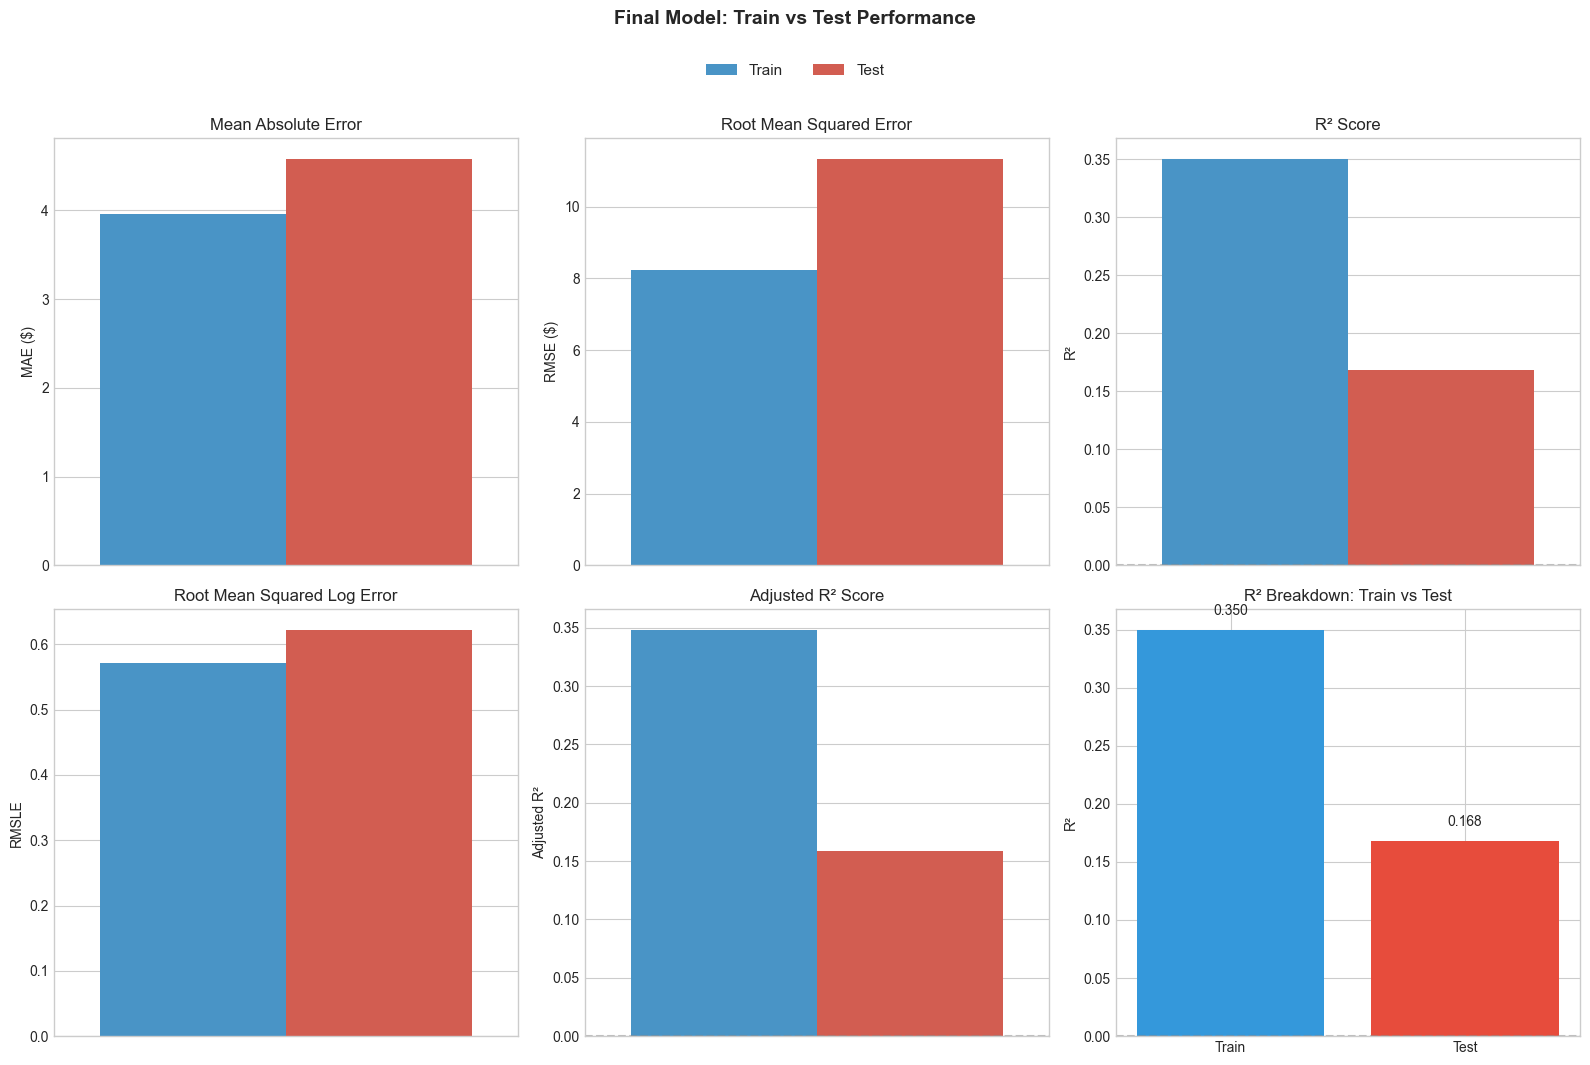

In [ ]:
# Visualize Train vs Test comparison
ROTATION = 0
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

plot_data = test_eval_df.copy()

# 1. MAE comparison
ax1 = axes[0, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train MAE', 'Test MAE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax1, palette=['#3498db', '#e74c3c'])
ax1.set_ylabel('MAE ($)')
ax1.set_title('Mean Absolute Error')
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.get_legend().remove()

# 2. RMSE comparison
ax2 = axes[0, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSE', 'Test RMSE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax2, palette=['#3498db', '#e74c3c'])
ax2.set_ylabel('RMSE ($)')
ax2.set_title('Root Mean Squared Error')
ax2.set_xticklabels([])
ax2.set_xlabel('')
ax2.get_legend().remove()

# 3. R² comparison
ax3 = axes[0, 2]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train R²', 'Test R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax3, palette=['#3498db', '#e74c3c'])
ax3.set_ylabel('R²')
ax3.set_title('R² Score')
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.get_legend().remove()

# 4. RMSLE comparison
ax4 = axes[1, 0]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train RMSLE', 'Test RMSLE'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax4, palette=['#3498db', '#e74c3c'])
ax4.set_ylabel('RMSLE')
ax4.set_title('Root Mean Squared Log Error')
ax4.set_xticklabels([])
ax4.set_xlabel('')
ax4.get_legend().remove()

# 5. Adjusted R² comparison
ax5 = axes[1, 1]
sns.barplot(data=plot_data.melt(id_vars=['Model'], value_vars=['Train Adj R²', 'Test Adj R²'],
            var_name='Set', value_name='Value'),
            x='Model', y='Value', hue='Set', ax=ax5, palette=['#3498db', '#e74c3c'])
ax5.set_ylabel('Adjusted R²')
ax5.set_title('Adjusted R² Score')
ax5.set_xticklabels([])
ax5.set_xlabel('')
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
handles, labels = ax5.get_legend_handles_labels()
ax5.get_legend().remove()

# 6. R² Breakdown - Train vs Test only
ax6 = axes[1, 2]
r2_labels = ['Train', 'Test']
r2_values = [0.35, 0.168]
colors = ['#3498db', '#e74c3c']
bars = ax6.bar(r2_labels, r2_values, color=colors)
ax6.set_ylabel('R²')
ax6.set_title('R² Breakdown: Train vs Test')
ax6.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
for bar, val in zip(bars, r2_values):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Single figure-level legend
labels_clean = ['Train', 'Test']
fig.legend(handles, labels_clean, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02), fontsize=11)

plt.suptitle('Final Model: Train vs Test Performance', fontsize=14, fontweight='bold', y=1.06)
plt.tight_layout()
plt.savefig('test_evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

Even with Colab's A100 GPU, our notebook requires several hours to complete a single run. This extended runtime makes iterative development extremely challenging any modification forces us to restart from scratch, consuming hours each time. Consequently, we were unable to implement the additional features we discussed.

This submission represents our final version after numerous trial runs and significant time investment. We apologize for not being able to deliver the full scope that was outlined during the presentations. Additionally, we encountered critical issues with LightGBM on Colab; even these high-performance machines struggle to handle the computations in a reasonable timeframe.